/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, 

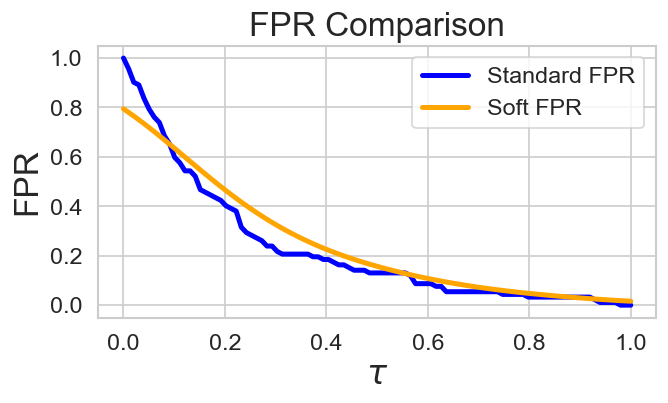

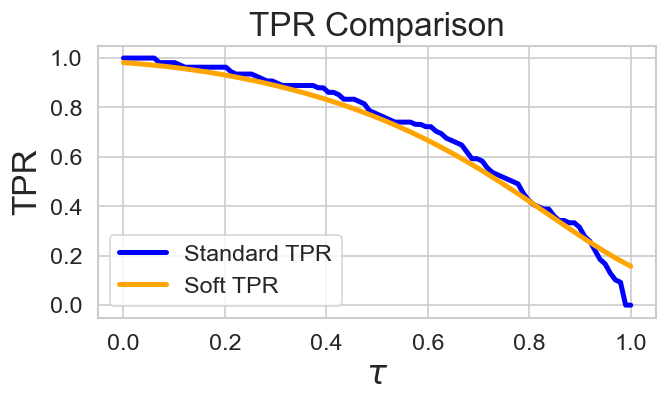

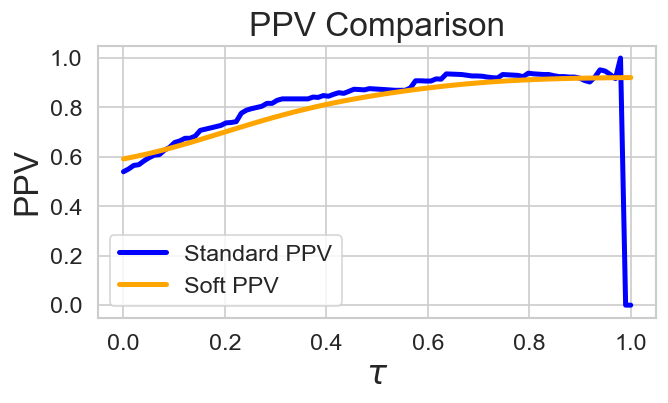

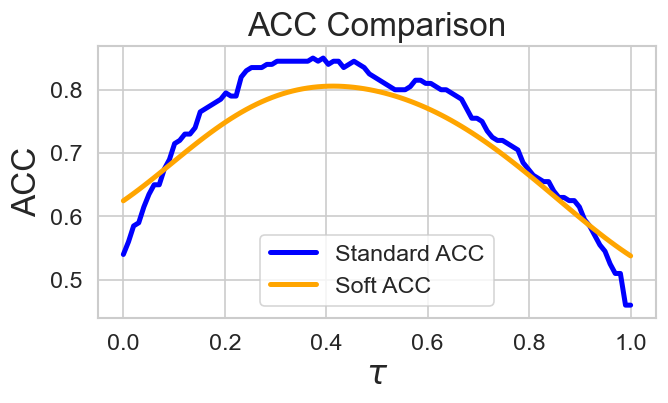

In [10]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def tpr_torch(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).float()
    TP = torch.sum((y_pred == 1) & (y_true == 1)).float()
    P = torch.sum(y_true == 1).float()
    return TP / P if P > 0 else torch.tensor(0.0)

def fpr_torch(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).float()
    FP = torch.sum((y_pred == 1) & (y_true == 0)).float()
    N = torch.sum(y_true == 0).float()
    return FP / N if N > 0 else torch.tensor(0.0)

def precision_torch(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).float()
    TP = torch.sum((y_pred == 1) & (y_true == 1)).float()
    FP = torch.sum((y_pred == 1) & (y_true == 0)).float()
    return TP / (TP + FP) if (TP + FP) > 0 else torch.tensor(0.0)

def accuracy_torch(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).float()
    TP = torch.sum((y_pred == 1) & (y_true == 1)).float()
    TN = torch.sum((y_pred == 0) & (y_true == 0)).float()
    P = torch.sum(y_true == 1).float()
    N = torch.sum(y_true == 0).float()
    return (TP + TN) / (P + N) if (P + N) > 0 else torch.tensor(0.0)

def sigmoid(x, beta=1.0):
    return 1 / (1 + torch.exp(-beta * x))

def precision_sigmoid(y_true, y_prob, threshold=0.5, beta=10):
    y_prob_sigmoid = sigmoid(y_prob - threshold, beta)
    TP_soft = torch.sum(y_prob_sigmoid * y_true)
    FP_soft = torch.sum(y_prob_sigmoid * (1 - y_true))
    denominator = TP_soft + FP_soft
    return TP_soft / denominator if denominator > 0 else torch.tensor(0.0)

def tpr_sigmoid(y_true, y_prob, threshold=0.5, beta=10):
    y_prob_sigmoid = sigmoid(y_prob - threshold, beta)
    TP = torch.sum(y_prob_sigmoid * y_true)
    P = torch.sum(y_true)
    return TP / P if P > 0 else torch.tensor(0.0)

def fpr_sigmoid(y_true, y_prob, threshold=0.5, beta=10):
    y_prob_sigmoid = sigmoid(y_prob - threshold, beta)
    FP = torch.sum(y_prob_sigmoid * (1 - y_true))
    N = torch.sum(1 - y_true)
    return FP / N if N > 0 else torch.tensor(0.0)

def accuracy_sigmoid(y_true, y_prob, threshold=0.5, beta=10):
    y_prob_sigmoid = sigmoid(y_prob - threshold, beta)
    TP = torch.sum(y_prob_sigmoid * y_true)
    TN = torch.sum((1 - y_prob_sigmoid) * (1 - y_true))
    total = y_true.numel()  # Total number of elements
    return (TP + TN) / total if total > 0 else torch.tensor(0.0)

def compare_metrics(y_true, y_prob, metric_hard, metric_soft, metric):
    thresholds = np.linspace(0, 1, 100)
    hard_values = np.array([metric_hard(y_true, y_prob, threshold).numpy() for threshold in thresholds])
    soft_values = np.array([metric_soft(y_true, y_prob, threshold).numpy() for threshold in thresholds])

    plt.figure(figsize=(6, 3), dpi=120)
    sns.set(style="whitegrid")

    sns.lineplot(thresholds, hard_values, label='Standard ' + metric, color="blue", linewidth=3)
    sns.lineplot(thresholds, soft_values, label='Soft ' + metric, color="orange", linewidth=3)

    plt.xlabel('$\\tau$', fontsize=20)
    plt.ylabel(metric, fontsize=20)
    plt.title(metric + ' Comparison', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.savefig('figs/' + metric + '_metric_comparison.pdf', bbox_inches='tight', dpi=120, format='pdf')

X, y = make_classification(n_samples=1000, n_features=14, n_informative=5,  n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_prob = torch.tensor(model.predict_proba(X_test)[:, 1])

y_true = torch.tensor(y_test).float()

compare_metrics(y_true, y_prob, fpr_torch, fpr_sigmoid, 'FPR')
compare_metrics(y_true, y_prob, tpr_torch, tpr_sigmoid, 'TPR')
compare_metrics(y_true, y_prob, precision_torch, precision_sigmoid, 'PPV')
compare_metrics(y_true, y_prob, accuracy_torch, accuracy_sigmoid, 'ACC')